In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Contents


1. The datasets
2. Patient
3. Tumour <br/>
&nbsp; 3.1  merge av_tumour and av_patient
4. sact_regimen
5. sact_tumour <br/>
&nbsp; 5.1  merge sact_tumour sact_regimen
6. sact_outcome <br/>
&nbsp; 6.1 merge sact_outcome and sact_regimen
7. sact_cycle
8. sact_patient
9. sact_drug_detail

# 1. The datasets

This is a table of all the columns in each dataset, there are a lot so it might be useful to see all of them in one table

In [2]:
datadict = pd.ExcelFile('Simulacrum-data-dictionary.xlsx')
sheets = datadict.sheet_names[1:]
DF = pd.DataFrame()
for sheet in sheets:
    df = pd.read_excel(datadict,sheet)
    df[sheet] = df['Field name']
    DF = pd.concat([DF,df[sheet]], axis=1)

DF

,AV_PATIENT,AV_TUMOUR,SACT PATIENT,SACT TUMOUR,SACT REGIMEN,SACT OUTCOME,SACT CYCLE,SACT DRUG_DETAIL
0,PATIENTID,TUMOURID,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_OUTCOME_ID,MERGED_CYCLE_ID,MERGED_DRUG_DETAIL_ID
1,SEX,PATIENTID,LINK_NUMBER,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_REGIMEN_ID,MERGED_CYCLE_ID
2,LINKNUMBER,DIAGNOSISDATEBEST,NaN,CONSULTANT_SPECIALITY_CODE,HEIGHT_AT_START_OF_REGIMEN,DATE_OF_FINAL_TREATMENT,CYCLE_NUMBER,ORG_CODE_OF_DRUG_PROVIDER
3,ETHNICITY,SITE_ICD10_O2,NaN,PRIMARY_DIAGNOSIS,WEIGHT_AT_START_OF_REGIMEN,REGIMEN_MOD_DOSE_REDUCTION,START_DATE_OF_CYCLE,ACTUAL_DOSE_PER_ADMINISTRATION
4,DEATHCAUSECODE_1A,SITE_ICD10_O2_3CHAR,NaN,MORPHOLOGY_CLEAN,INTENT_OF_TREATMENT,REGIMEN_MOD_TIME_DELAY,OPCS_PROCUREMENT_CODE,OPCS_DELIVERY_CODE
5,DEATHCAUSECODE_1B,MORPH_ICD10_O2,NaN,NaN,DATE_DECISION_TO_TREAT,REGIMEN_MOD_STOPPED_EARLY,PERF_STATUS_START_OF_CYCLE,ADMINISTRATION_ROUTE
6,DEATHCAUSECODE_1C,BEHAVIOUR_ICD10_O2,NaN,NaN,START_DATE_OF_REGIMEN,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,ADMINISTRATION_DATE
7,DEATHCAUSECODE_2,T_BEST,NaN,NaN,MAPPED_REGIMEN,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,DRUG_GROUP
8,DEATHCAUSECODE_UNDERLYING,N_BEST,NaN,NaN,CLINICAL_TRIAL,MERGED_TUMOUR_ID,NaN,MERGED_PATIENT_ID
9,DEATHLOCATIONCODE,M_BEST,NaN,NaN,CHEMO_RADIATION,NaN,NaN,MERGED_TUMOUR_ID


<img src="tablestructure.jpeg" alt="ts" width="500"/>

# 2. Patient

In [3]:
av_patient = pd.read_csv('simulacrum_release_v1.1.0/sim_av_patient.csv')
display(av_patient.head())

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


frequency of each death cause:

[Text(0,0,'deathcause')]

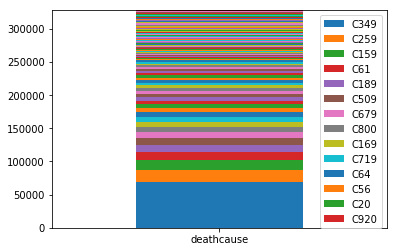

In [4]:
vc = av_patient['DEATHCAUSECODE_UNDERLYING'].value_counts()
ax = pd.DataFrame(vc).T.plot.bar(stacked=True)
ax.legend(vc.keys()[0:14]);
ax.set_xticklabels(labels=['deathcause'],rotation=0)

# 3. Tumour

In [5]:
av_tumour = pd.read_csv('simulacrum_release_v1.1.0/sim_av_tumour.csv',low_memory=False)
display(av_tumour.head())
print(av_tumour.shape)

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-06,L,3
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-06,8,2
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1 - least deprived
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,2
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-11-01,8,2


(1402817, 34)


Making some bar plots of the tumour features, colour coded with the tumour site:

In [6]:
tumour_features = av_tumour[['SITE_ICD10_O2_3CHAR', 'BEHAVIOUR_ICD10_O2', 'T_BEST',
                            'N_BEST', 'M_BEST', 'STAGE_BEST', 'STAGE_BEST_SYSTEM', 'GRADE', 'AGE',
                            'CANCERCAREPLANINTENT', 'PERFORMANCESTATUS', 'ACE27','LATERALITY']]
vc = av_tumour['SITE_ICD10_O2_3CHAR'].value_counts()
vc[:20] #top20tumoursites

C44    350130
C50    133907
C61    119347
C34    102350
D06     76678
C18     65825
C43     38155
C20     27163
C64     26195
D09     25193
C67     24643
C54     21849
C25     21344
C15     20996
D05     19777
C83     18264
D03     17123
C56     16939
C16     15298
C90     13504
Name: SITE_ICD10_O2_3CHAR, dtype: int64

The colours in these plots are the site of the tumour, the legend only shows the top 20 sites

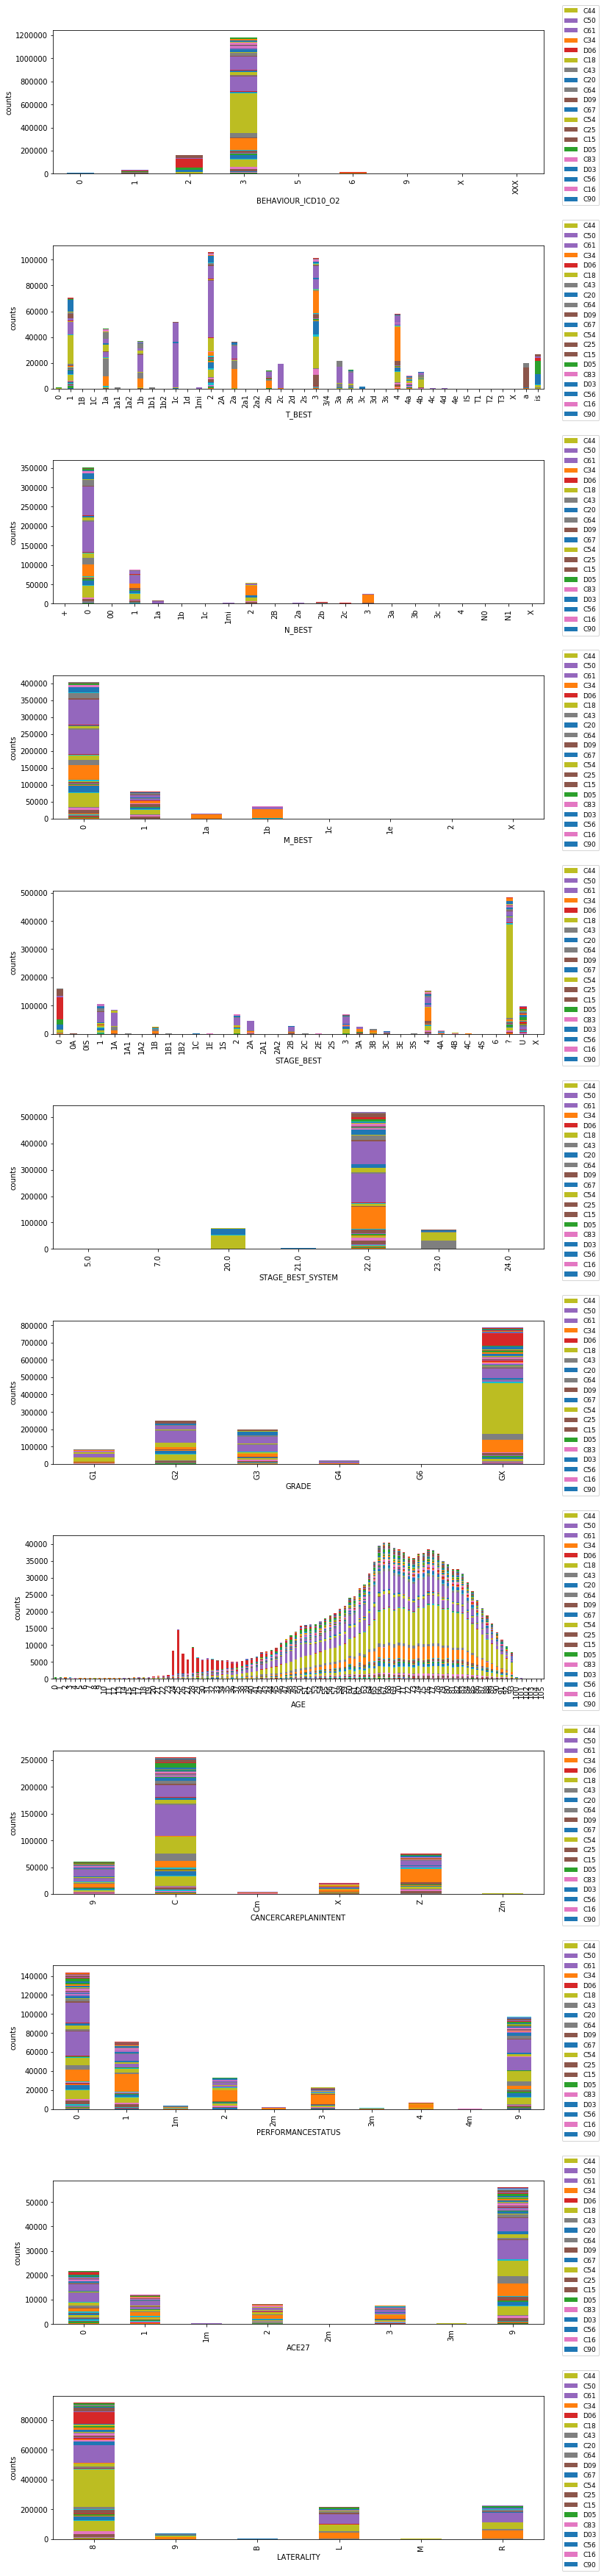

In [7]:
tf_keys = list(tumour_features.keys())
tf_keys.remove('SITE_ICD10_O2_3CHAR')
fig, axes = plt.subplots(nrows=len(tf_keys), ncols=1, figsize=(10,4*len(tf_keys)))
fig.tight_layout()
for i,col in enumerate(tf_keys):
    
    feature = tumour_features[['SITE_ICD10_O2_3CHAR',col]] \
                        .groupby([col, 'SITE_ICD10_O2_3CHAR']) \
                        .agg({'SITE_ICD10_O2_3CHAR':'size'}) \
                        .rename(columns={'SITE_ICD10_O2_3CHAR':'site count'}) \
                        .reset_index()
    feature = feature.pivot(index=col, columns='SITE_ICD10_O2_3CHAR')['site count']
    ax = feature.plot(kind='bar', stacked=True, ax=axes[i])
    handles, labels = ax.get_legend_handles_labels()
    top20index = [labels.index(v) for v in vc[:20].keys()]
    top20handles = [handles[i] for i in top20index]
    ax.legend(top20handles, vc[:20].keys(),loc='best', bbox_to_anchor=(0.62, 0.7, 0.5, 0.5),prop={'size':9})
    ax.set_ylabel('counts')
plt.subplots_adjust(hspace=0.5)

### 3.1 merge av_tumour and av_patient

In [9]:
tumour_patient = pd.merge(av_tumour,av_patient,on='PATIENTID')
print(av_tumour.shape,av_patient.shape,tumour_patient.shape) 

(1402817, 34) (1322100, 12) (1402817, 45)


create column with days between date of vital status taken and date of diagnosis

In [10]:
from datetime import date

diagnosis_dates = pd.to_datetime(tumour_patient['DIAGNOSISDATEBEST'])
vitalstat_dates = pd.to_datetime(tumour_patient['VITALSTATUSDATE'])

tumour_patient['VITAL - DIAGNOSIS (days)'] = vitalstat_dates - diagnosis_dates
tumour_patient['VITAL - DIAGNOSIS (days)'] = [i.days for i in tumour_patient['VITAL - DIAGNOSIS (days)']]
tumour_patient = tumour_patient[tumour_patient['VITAL - DIAGNOSIS (days)'] >= 0] #some have vital status in 1900

print("stats for days being alive")
tumour_patient['VITAL - DIAGNOSIS (days)'].describe()

stats for days being alive


count    1.402784e+06
mean     7.674820e+02
std      4.079234e+02
min      0.000000e+00
25%      4.660000e+02
50%      7.690000e+02
75%      1.105000e+03
max      1.484000e+03
Name: VITAL - DIAGNOSIS (days), dtype: float64

plots of mean days alive from patients that died

In [11]:
dead_patient = tumour_patient[tumour_patient['NEWVITALSTATUS'] == 'D']

time_behav = dead_patient[dead_patient['BEHAVIOUR_ICD10_O2'] != 'XXX'].dropna(subset=['BEHAVIOUR_ICD10_O2'])
time_behav['BEHAVIOUR_ICD10_O2'] = time_behav['BEHAVIOUR_ICD10_O2'].astype(int)
time_behav['VITAL - DIAGNOSIS (days)'] = time_behav['VITAL - DIAGNOSIS (days)'].astype(float)
mean_days_alive = time_behav[['SITE_ICD10_O2_3CHAR','BEHAVIOUR_ICD10_O2' , 'VITAL - DIAGNOSIS (days)']] \
                    .groupby(['SITE_ICD10_O2_3CHAR','BEHAVIOUR_ICD10_O2']) \
                    .agg({'SITE_ICD10_O2_3CHAR':'size', 'VITAL - DIAGNOSIS (days)':'mean'}) \
                    .rename(columns={'SITE_ICD10_O2_3CHAR':'site count','VITAL - DIAGNOSIS (days)':'mean days alive'}) \
                    .reset_index()

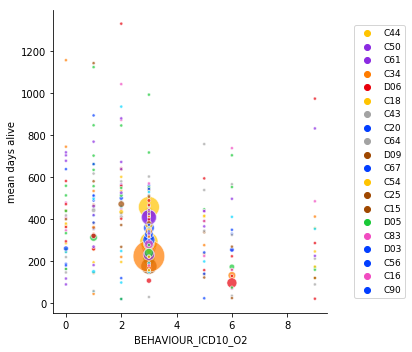

In [12]:
p = sns.relplot(x="BEHAVIOUR_ICD10_O2", y="mean days alive", hue="SITE_ICD10_O2_3CHAR", size="site count",
            sizes=(10, 1000), alpha=.7, palette="bright",
            height=5, data=mean_days_alive)
handles, labels = p.ax.get_legend_handles_labels()
top20index = [labels.index(v) for v in vc[:20].keys()]
top20handles = [handles[i] for i in top20index]
p.ax.legend(top20handles, vc[:20].keys(),loc='right', bbox_to_anchor=(0.8, 0.25, 0.5, 0.5),prop={'size':9})
p._legend.remove()

On the legend is the top 20 tumour

Different colors mean different tumour sites

The sizes of the blobs represent the number of people who have that tumour

There isn't a clear correlation between the time alive and the behaviour of the tumour(how bad the tumour is)

# 4. Sact_regimen

https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python - loading sim_sact_regimen

In [13]:
sact_regimen = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_regimen.csv',encoding="ISO-8859-1")
sact_regimen.head()

,MERGED_REGIMEN_ID,MERGED_TUMOUR_ID,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID,BENCHMARK_GROUP
0,10000001,10000001,-1.0,NaN,N,2015-03-08,2015-03-08,DEGARELIX,NaN,N,10000235,HORMONES
1,10000002,10000002,NaN,NaN,P,2016-07-09,2016-07-10,BICALUTAMIDE + GOSERELIN,NaN,N,10000315,HORMONES
2,10000003,10000003,NaN,NaN,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES
3,10000004,10000004,NaN,NaN,NaN,2015-03-17,2015-03-23,Rituximab,N,NaN,10000480,RITUXIMAB
4,10000005,10000005,0.0,NaN,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE


there are multiple regimens for some tumours

# 5. Sact_tumour

In [14]:
sact_tumour = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_tumour.csv')
sact_tumour.head()

,MERGED_TUMOUR_ID,MERGED_PATIENT_ID,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN
0,10000001,10000235,101.0,C61,81403.0
1,10000002,10000315,101.0,C679,81403.0
2,10000003,10000337,100.0,C500,NaN
3,10000004,10000480,303.0,C829,NaN
4,10000005,10000533,823.0,D473,NaN


### 5.1 merge sact_tumour sact_regimen

In [15]:
tumour_regimen = pd.merge(sact_tumour,sact_regimen,on='MERGED_TUMOUR_ID')
print(sact_tumour.shape, sact_regimen.shape, tumour_regimen.shape) 

(299727, 5) (471919, 12) (471919, 16)


Text(0,0.5,'counts')

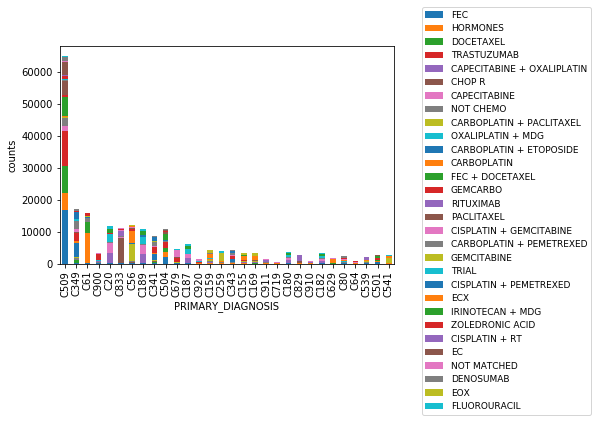

In [16]:
col = 'PRIMARY_DIAGNOSIS'
regimen_feature = tumour_regimen[['BENCHMARK_GROUP',col]] \
                    .groupby([col, 'BENCHMARK_GROUP']) \
                    .agg({'BENCHMARK_GROUP':'size'}) \
                    .rename(columns={'BENCHMARK_GROUP':'Regimen count'}) \
                    .reset_index()
regimen_feature = regimen_feature.pivot(index=col, columns='BENCHMARK_GROUP')['Regimen count']

#top30 diagnosis
vcdiagnosis = tumour_regimen['PRIMARY_DIAGNOSIS'].value_counts()
regimen_feature = regimen_feature.loc[list(vcdiagnosis[:30].keys())]

#top30 regimens
vc = tumour_regimen['BENCHMARK_GROUP'].value_counts()
topreg = regimen_feature[list(vc[:30].keys())]


ax = topreg.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.1, 0.7, 0.5, 0.5),prop={'size':9})
ax.set_ylabel('counts')


This is a frequency plot of primary diagnosis of patients with the different colours as the BENCHMARK_GROUP(type of regimen i think) given to that patient.

this only shows the top 30 PRIMARY_DIAGNOSIS and top 30 BENCHMARK_GROUP

# 6. sact_outcome

In [17]:
sact_outcome = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_outcome.csv')
sact_outcome.head()

,MERGED_OUTCOME_ID,MERGED_REGIMEN_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000003,2014-01-09,N,N,N,NaN,10000337,10000003
1,10000002,10000005,NaN,Y,Y,N,NaN,10000533,10000005
2,10000003,10000006,NaN,N,Y,N,NaN,10000697,10000006
3,10000004,10000007,NaN,Y,NaN,N,NaN,10000697,10000006
4,10000005,10000008,2012-12-07,NaN,NaN,NaN,NaN,10000773,10009036


### 6.1 merge sact_outcome and sact_regimen

In [18]:
outcome_regimen = pd.merge(sact_regimen,sact_outcome,on='MERGED_REGIMEN_ID')
print(sact_outcome.shape, sact_regimen.shape, outcome_regimen.shape) 

(351668, 9) (471919, 12) (351668, 20)


Text(0,0.5,'counts')

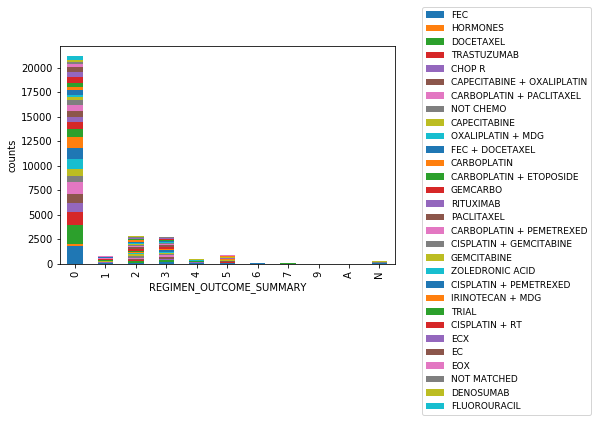

In [19]:
col = 'REGIMEN_OUTCOME_SUMMARY'
regimen_feature = outcome_regimen[['BENCHMARK_GROUP',col]] \
                    .groupby([col, 'BENCHMARK_GROUP']) \
                    .agg({'BENCHMARK_GROUP':'size'}) \
                    .rename(columns={'BENCHMARK_GROUP':'Regimen count'}) \
                    .reset_index()
regimen_feature = regimen_feature.pivot(index=col, columns='BENCHMARK_GROUP')['Regimen count']

vc = outcome_regimen['BENCHMARK_GROUP'].value_counts()
topreg = regimen_feature[list(vc[:30].keys())]
ax = topreg.plot(kind='bar', stacked=True)
ax.legend(bbox_to_anchor=(1.1, 0.7, 0.5, 0.5),prop={'size':9})
ax.set_ylabel('counts')

This is a frequency plot of REGIMEN_OUTCOME_SUMMARY with the different colours as the BENCHMARK_GROUP.

# 7. sact_cycle

In [20]:
sact_cycle = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_cycle.csv', low_memory=False)
display(sact_cycle.head())

print('shape ',sact_cycle.shape)

for col in list(sact_cycle.columns):
    print(col," ",sact_cycle[col].unique()[0:6])

,MERGED_CYCLE_ID,MERGED_REGIMEN_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000001,4,2015-06-07,NaN,NaN,10000235,10000001
1,10000002,10000002,2,2016-08-07,NaN,00,10000315,10000002
2,10000003,10000003,3,NaN,X715,NaN,10000337,10000003
3,10000004,10000004,2,2015-03-23,X712,0,10000480,10000004
4,10000005,10000005,1,2013-03-11,X711,NaN,10000533,10000005


shape  (1462099, 8)
MERGED_CYCLE_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
MERGED_REGIMEN_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
CYCLE_NUMBER   [ 4  2  3  1  5 11]
START_DATE_OF_CYCLE   ['2015-06-07' '2016-08-07' nan '2015-03-23' '2013-03-11' '2012-06-29']
OPCS_PROCUREMENT_CODE   [nan 'X715' 'X712' 'X711' 'X713' 'X702']
PERF_STATUS_START_OF_CYCLE   [nan '00' '0' '1' '-1' '2']
MERGED_PATIENT_ID   [10000235 10000315 10000337 10000480 10000533 10000697]
MERGED_TUMOUR_ID   [10000001 10000002 10000003 10000004 10000005 10000006]


# 8. sact_patient

In [21]:
sact_patient = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_patient.csv')
display(sact_patient.head())

print('shape ',sact_patient.shape)

for col in list(sact_patient.columns):
    print(col," ",sact_patient[col].unique()[0:6])

,MERGED_PATIENT_ID,LINK_NUMBER
0,10000087,810000087
1,10000235,810000235
2,10000283,810000283
3,10000315,810000315
4,10000337,810000337


shape  (245938, 2)
MERGED_PATIENT_ID   [10000087 10000235 10000283 10000315 10000337 10000365]
LINK_NUMBER   [810000087 810000235 810000283 810000315 810000337 810000365]


# 9. sact_drug_detail

In [22]:
drug_detail = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_drug_detail.csv')
display(drug_detail.head())

print('shape ',drug_detail.shape)

for col in list(drug_detail.columns):
    print(col," ",drug_detail[col].unique()[0:6])

,MERGED_DRUG_DETAIL_ID,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,10000001,10000001,EKD02,10.0,NaN,1.0,2015-06-07,STEROID,10000235,10000001,10000001
1,10000002,10000002,EGU02,30.0,NaN,2.0,NaN,NOT CHEMO,10000315,10000002,10000002
2,10000003,10000003,EGU05,1000.0,NaN,1.0,NaN,RITUXIMAB,10000337,10000003,10000003
3,10000004,10000004,EXO,8.0,X723,2.0,2015-03-23,NOT CHEMO,10000480,10000004,10000004
4,10000005,10000005,ETD02,1000.0,NaN,2.0,2013-03-11,NOT CHEMO,10000533,10000005,10000005


shape  (3544584, 11)
MERGED_DRUG_DETAIL_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
MERGED_CYCLE_ID   [10000001 10000002 10000003 10000004 10000005 10000007]
ORG_CODE_OF_DRUG_PROVIDER   ['EKD02' 'EGU02' 'EGU05' 'EXO' 'ETD02' 'ETA42']
ACTUAL_DOSE_PER_ADMINISTRATION   [  10.   30. 1000.    8.  300.  100.]
OPCS_DELIVERY_CODE   [nan 'X723' 'X731' 'x723' 'X729' 'x721']
ADMINISTRATION_ROUTE   [ 1.  2.  5. nan 99.  4.]
ADMINISTRATION_DATE   ['2015-06-07' nan '2015-03-23' '2013-03-11' '2014-07-25' '2012-12-07']
DRUG_GROUP   ['STEROID' 'NOT CHEMO' 'RITUXIMAB' 'DOCETAXEL' 'PACLITAXEL' 'CARBOPLATIN']
MERGED_PATIENT_ID   [10000235 10000315 10000337 10000480 10000533 10000697]
MERGED_TUMOUR_ID   [10000001 10000002 10000003 10000004 10000005 10000006]
MERGED_REGIMEN_ID   [10000001 10000002 10000003 10000004 10000005 10000007]
